In [21]:
# Set up
%pylab
%pylab inline
%matplotlib inline
%load_ext autoreload
%autoreload 2
import tqdm
import random
import pandas as pd
from sklearn import datasets
import sklearn
import seaborn as sns
from PIL import Image
import scipy
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib
Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
class K_MEANS:
    '''
    Divides given data into K clusters.
    
    Fields:
        df: Dataset without 'target' attribute
        N: Size of dataset
        k: Number of clusters
        MAX_ITER: Number of iterations
        labels: Class of each sample
        centroids: N x 2 array with coordinates of centroids
        distances: N x N matrix of distances, where len(df) = N
    '''
    
    def __init__(self, data, k = 3, MAX_ITER = 100):
        self.df = np.array(data)
        (self.N, self.M) = self.df.shape
        self.k = k;
        self.MAX_ITER = MAX_ITER
        self.iterations = 0
        self.labels = np.zeros(self.N, dtype=np.int)
        self.centroids = self.random_centroids()
        self.distances = self.compute_distances()
       
        
    def random_centroids(self):
        '''
        Returns:
            List of random k indices
        '''
        centrs = random.sample(range(self.N), self.k)
        return self.df[centrs]
    
    
    def compute_distances(self):
        '''
        Returns: 
            N x N matrix of distances
        '''
        X, Y = self.df, self.centroids
        dists = -2 * np.dot(X, Y.T) + np.sum(Y ** 2, axis=1)
        return dists
        
    
    def assign_centroids(self):
        '''
        Find closest centroid for each data sample
        
        Returns:
            True: Found new centroids
            False: Centroids are the same
        '''
        self.distances = self.compute_distances()
        nearest_centroids = np.argmin(self.distances, axis=1)
        
        if abs(np.sum(nearest_centroids - self.labels)) < 1e-100:
            return False
        
        self.labels = nearest_centroids
        return True
    
    
    def update_centroids(self):
        '''
        Determine new centroids by taking the average of all the points assigned to that cluster.
        '''
        new_centroids = np.zeros(self.k * self.M).reshape(self.k, self.M)
        centroid_cnt = np.full(self.k, 1e-100)
        for i in range(self.k):
            assigned_to_ith = self.labels == i
            new_centroids[i] += np.sum(self.df[assigned_to_ith], axis=0)
            centroid_cnt[i] += len(self.df[assigned_to_ith])
            
        self.centroids = new_centroids / centroid_cnt[:, np.newaxis]
        
    
    def RUN(self, show_images=False):
        '''
        Runs KMEANS algorithms as long as we can update centroids or till we reach MAX_ITER
        
        Parameters:
            show_images: True / False - either shows or does not show images
                         For a integer 'i' shows every ith image 
        '''
        for no in tqdm.tqdm(range(self.MAX_ITER)):
            self.iterations = no
            if not self.assign_centroids():
                if show_images:
                    self.plot_2d()
                break
            
            if show_images and no % show_images == 0:
                self.plot_2d()
                
            self.update_centroids()
    
    def plot_2d(self):
        plt.figure(dpi=100)
        plt.title(f'Iterations: {self.iterations}')
        plt.scatter(self.df[:, 0], self.df[:, 1], c=self.labels, edgecolor='black', s=20, alpha=1)
        plt.scatter(self.centroids[:, 0], self.centroids[:, 1], c=range(self.k), edgecolor='red', s=100, alpha=0.8)
        plt.show()
        
        
    def plot_before_and_after_2d(self, X, Y):
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(20,5)
        ax1.scatter(self.df[:, 0], self.df[:, 1], c='white', edgecolor='black', s=20, alpha=0.5)
        ax2.scatter(self.df[:, 0], self.df[:, 1], c=self.labels, edgecolor='black', s=20, alpha=1)
        ax2.scatter(self.centroids[:, 0], self.centroids[:, 1], c=range(self.k), edgecolor='red', s=100, alpha=0.8)
        ax1.set_xlim(X)
        ax1.set_ylim(Y)
        ax2.set_xlim(X)
        ax2.set_ylim(Y)
        
        
    def plot_before_and_after_3d(self):
        fig = plt.figure(figsize=(20, 8))
        # 121 - 1 x 2 grid 1st subplot
        ax1 = fig.add_subplot(121, projection='3d')
        ax2 = fig.add_subplot(122, projection='3d')
        ax1.scatter(self.df[:, 0], self.df[:, 1], self.df[:, 2], c='white', edgecolor='black', s=20, alpha=0.5)
        ax2.scatter(self.df[:, 0], self.df[:, 1], self.df[:, 2], c=self.labels, edgecolor='black', s=20, alpha=1)
        ax2.scatter(self.centroids[:, 0], self.centroids[:, 1], self.centroids[:, 2],  c=range(self.k), edgecolor='red', s=100, alpha=0.8)
    

# Zadanie 4. (2 punkty)
Zdjęcie fotograficzne o rozdzielczości A x B w formacie RGB można traktować jako zbiór N = A * B <br/>
trójwymiarowych punktów danych. Po przeprowadzeniu grupowania takich danych, z liczbą grup K, <br/>
można obniżyć liczbę kolorów zdjęcia do K (tworząc paletę K kolorów określonych przez środki <br/>
uzyskanych grup, a następnie zastępując kolor każdego piksela najbliższym mu kolorem ze <br/>
stworzonej palety). Napisz program wczytujący zdjęcie z pliku JPG, <br/>
redukujący liczbę kolorów w powyższy sposób i wyświetlający zredukowane <br/>
zdjęcie na ekranie. Sprawdź działanie programu na 5 wybranych przez siebie zdjęciach. <br/>

In [175]:
def compress_image_RGB(img, colors=3):
    img_arr = np.array(img)
    X = img_arr.reshape(-1, img_arr.shape[-1])
    
    KM = K_MEANS(X, k=colors, MAX_ITER=100)
    KM.RUN(show_images=False)
    
    final_colors = img_arr.reshape(-1, img_arr.shape[-1])
    grouping = KM.labels
    centroid_colors = KM.centroids.reshape(KM.k, train.shape[-1])

    for i in range(KM.k):
        final_colors[grouping == i] = centroid_colors[i]

    final_colors = final_colors.reshape(img_arr.shape)
    im = Image.fromarray(final_colors, 'RGB')
    
    return im

def show_images(img, colors=3):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,10))
    compressed_image = compress_image_RGB(img, colors)
    ax1.imshow(img)
    ax1.set_title('Original Image')
    ax2.imshow(compressed_image)
    ax2.set_title(f'Image compressed with {colors} colors')

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:11<00:00,  1.32s/it]


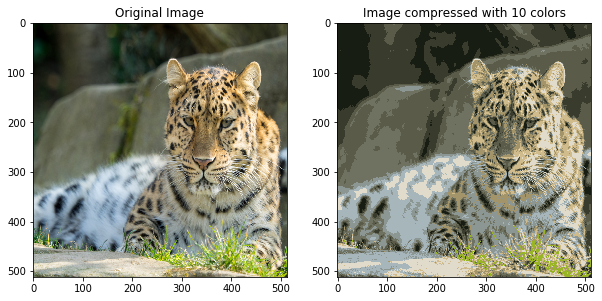

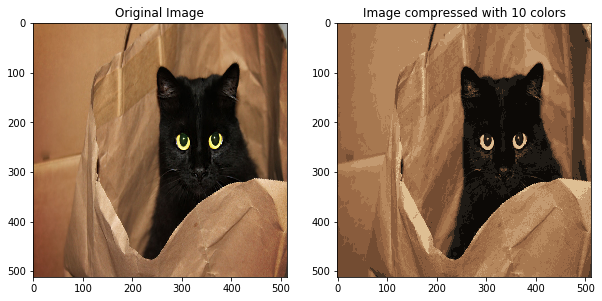

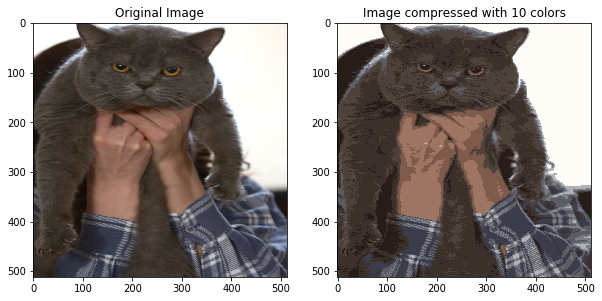

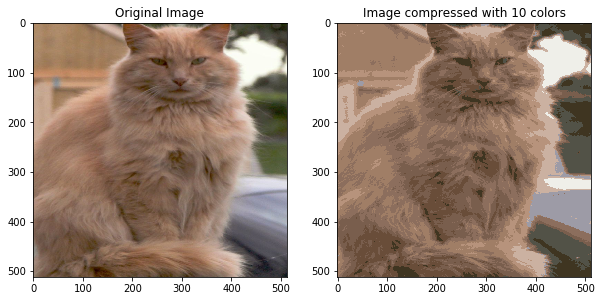

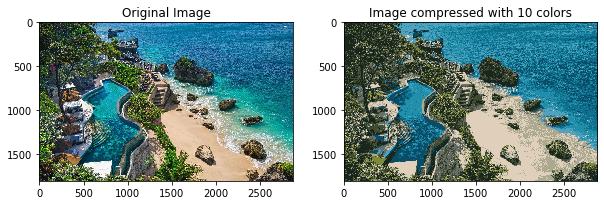

In [180]:
Images = [Image.open('Images/small1.png'),
          Image.open('Images/small2.png'),
          Image.open('Images/medium1.png'),
          Image.open('Images/medium2.png'),
          Image.open('Images/HD1.jpg'),
         ]     

for img in Images:
    show_images(img, colors=10)

# Zadanie 5. (2 punkty)
Zbiór danych Kosarak (stworzony przez Ferenca Bodona, dostępny m.in. na http://fimi.ua.ac.be/data/kosarak.dat.gz) 
zawiera informacje o transakcjach zawartych w sieci supermarketów. <br/>
Każdy wiersz tego pliku reprezentuje jedną transakcję i zawiera identyfikatory produktów kupionych w tej transakcji. <br/>
- a) Wyznacz T = 1000 najczęściej kupowanych produktów (tzn. produktów, które pojawiły się w największej liczbie transakcji). Oznaczmy je kolejno Z1, Z2, …, ZT.
- b) Dla każdego produktu, policz ile razy był on kupowany razem z produktem Zi (dla i =1, 2, …, T) tworząc w ten sposób wektor liczbowy p = (p1, p2, …, pT) opisujący dany produkt.
- c) Pogrupuj produkty używając ich powyższej reprezentacji oraz algorytmu K-Means z różną liczbą grup (poeksperymentuj).
Przedstaw wyniki swoich eksperymentów. Możesz także poeksperymentować z parametrem T. <br/>
Które grupy produktów można uznać za szczególnie istotne, a które za raczej przypadkowe?  <br/>

In [3]:
from collections import Counter
kosarak_df = pd.read_csv('http://fimi.ua.ac.be/data/kosarak.dat.gz')

In [4]:
kosarak_df.head()

,1 2 3
0,1
1,4 5 6 7
2,1 8
3,9 10
4,11 6 12 13 14 15 16


In [6]:
kosarak_as_array = [[int(z) for z in y.split()] for y in kosarak_df['1 2 3']]

In [7]:
cnt = {}
for row in kosarak_as_array:
    for x in row:
        cnt[x] = cnt.get(x, 0) + 1
        
cnt = dict(sorted(cnt.items(), key=lambda x: x[1], reverse=True))

In [8]:
# a)
T = np.array(list(cnt.items())[:1000])
index = {}
for i, item in enumerate(T):
    index[item[0]] = i

In [9]:
# b)
items_from_T = set(T[:, 0])
mx = max(cnt.keys())
bought_with_T = np.zeros((mx + 1) * 1000).reshape(mx + 1, 1000)
for row in tqdm.tqdm(kosarak_as_array):
    for i in range(len(row)):
        for j in range(i + 1, len(row)):
            if row[j] in items_from_T and row[j] != row[i]:
                bought_with_T[row[i]][index[row[j]]] += 1

100%|████████████████████████████████████████████████████████████████████████| 990001/990001 [03:11<00:00, 5172.30it/s]


In [10]:
bought_with_T.astype(np.int)

array([[     0,      0,      0, ...,      0,      0,      0],
       [132113,  84659,      0, ...,    386,    585,    708],
       [     0,  19437,      0, ...,    161,    117,    129],
       ...,
       [     0,      1,      0, ...,      0,      0,      0],
       [     0,      0,      0, ...,      0,      0,      0],
       [     0,      1,      0, ...,      0,      0,      0]])

In [11]:
# c)
KM = K_MEANS(bought_with_T, k=3, MAX_ITER=100)
KM.RUN(show_images=False)

 32%|█████████████████████████▉                                                       | 32/100 [00:13<00:28,  2.36it/s]

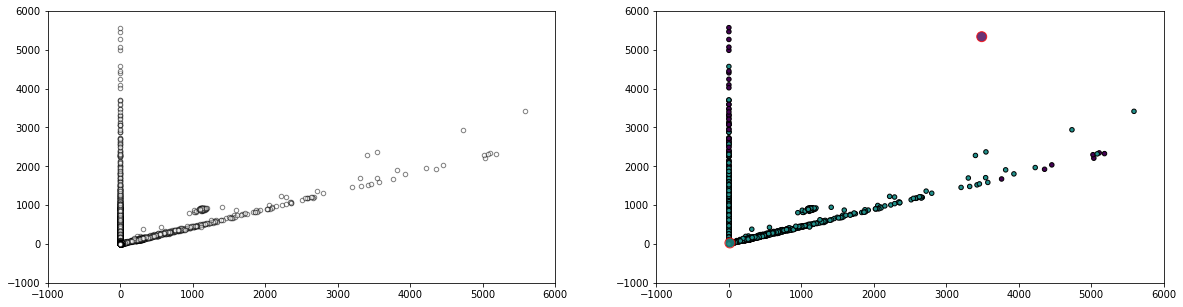

In [15]:
KM.plot_before_and_after_2d([-1000, 6000], [-1000, 6000])

In [40]:
# Lets try PCA
from sklearn.decomposition import PCA
shop_df = pd.DataFrame(bought_with_T)
shop_df.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,132113.0,84659.0,0.0,0.0,32127.0,23817.0,0.0,0.0,28049.0,12963.0,...,724.0,735.0,416.0,671.0,0.0,415.0,533.0,386.0,585.0,708.0
2,0.0,19437.0,0.0,0.0,0.0,7840.0,0.0,0.0,6212.0,3023.0,...,142.0,157.0,136.0,131.0,0.0,161.0,146.0,161.0,117.0,129.0
3,0.0,0.0,0.0,0.0,0.0,38659.0,0.0,0.0,30330.0,0.0,...,0.0,0.0,560.0,559.0,0.0,560.0,533.0,574.0,544.0,504.0
4,45377.0,35438.0,0.0,14645.0,6648.0,6693.0,0.0,5398.0,5196.0,4892.0,...,96.0,109.0,103.0,97.0,0.0,111.0,81.0,95.0,80.0,84.0


In [41]:
pca = PCA(n_components=2, svd_solver='auto').fit(shop_df)
shop_df_pca=pca.transform(shop_df)

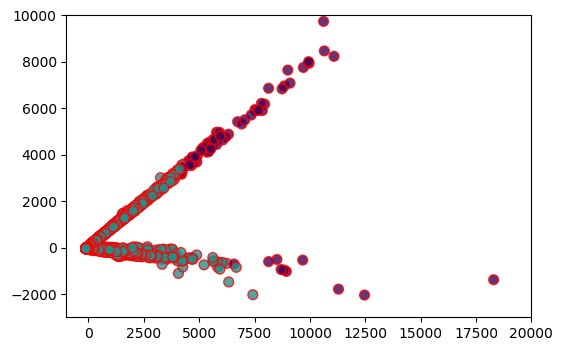

In [61]:
plt.figure(dpi=100)
plt.scatter(shop_df_pca[:, 0], shop_df_pca[:, 1], c=KM.labels, edgecolor='red', s=50, alpha=0.8)
plt.xlim(-1000,20000)
plt.ylim(-3000,10000)
plt.show()